# You can autodiff ordinary differential equations with `jax`

The applications of Autodiff are even more general than shown so far. We can use autodiff to compute differential equations and then back-propagate through those differential equations.  Since Jax doesn't mind taking high order gradients, it's all free (if you can fit your problem in memory).

Let's consider our ultimate goal-- radiative transfer equations in exoplanetary or astrophysical atmospheres.

> Anywhere that the radiative transfer equations are solved through integration can just as well be rewritten as their differential forms, and restructured as a Loss term. Then the solution to the differential equation can be initialized (possibly with a good guess from intuition or previous simulations) and then the loss term can be minimized just like any other chi-squared minimization (or back-propagation) type problem. You tune how good the solution has to be with an epsilon parameter that looks like sigma in chi squared. So now you can run a retrieval and for a given P-T profile, you can add a Loss term to your conventional chi-squared which says how physical your model is. But the key idea is that 1) you minimize both conventional chi squared and this new loss term through the exact gradient of autodiff, 2) the new loss term (or terms) are by definition partial differential equations but it's free (or at least cheap) to take higher order derivatives in Jax, so you can do things like take the derivative of a second derivative (a net third order derivative) which you could never do numerically due to both computational cost and loss of accuracy. 

   -me, in a Slack message to Natasha Batalha

Here's a simple example for the equations of motion of a mass on a spring, using Hooke's law.

Imagine I have data (with error bars) for the path of a mass on a spring. The allowed path governed by physics is a second order ordinary differential equation: 
$$\vec{F} = m\vec{a} = -k \vec{x}$$

$$m \ddot{x} + k x = 0 $$

We know the solution to this is $$x(t) = A sin(\sqrt{\frac{k}{m}} x) + Bcos(\sqrt{\frac{k}{m}} x)$$

with $\omega \equiv \sqrt{k/m}$ often defined as the natural frequency of oscillation:
$$\ddot{x} + \omega^2 x = 0 $$

Let's make some fake data and see if Jax can fit the data without knowing the answer.

In [1]:
import numpy as onp

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
t = onp.arange(0, 10, 0.01)

We can set $\omega = \sqrt{k/m}$

In [4]:
A, omega = 3.5, 2.1
sigma = 0.42

In [5]:
x_noise_free = A * onp.sin(omega*t)
x_data = x_noise_free + onp.random.normal(scale=sigma, size=len(t))

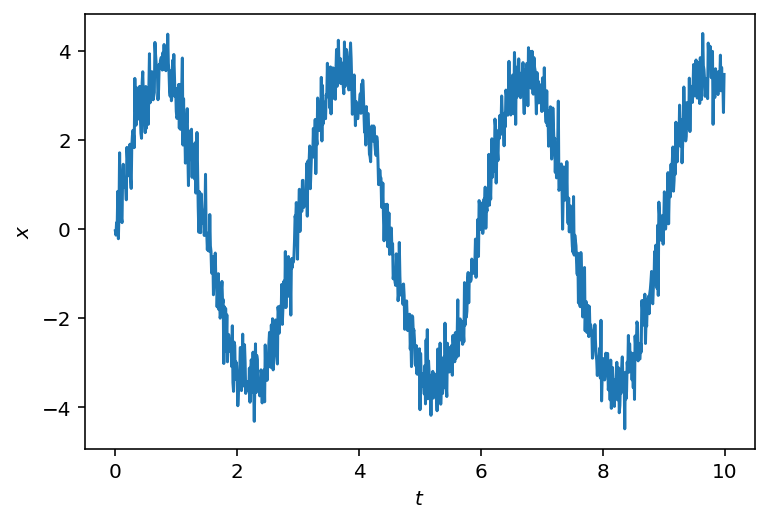

In [6]:
plt.plot(t, x_data); plt.xlabel('$t$'); plt.ylabel('$x$');

Now let's fit that data with a non-parametric function.

In [7]:
from jax.config import config
config.update("jax_enable_x64", True)

In [8]:
import jax.numpy as np

Let's model the data using the general form.

In [9]:
def true_model(params, t=None):
    '''Return x(t) given params'''
    A, omega = params
    x = A * np.sin(omega*t) #+ B * np.cos(omega*t)
    return x

In [10]:
guess = np.array([1.7, 1.67])
x_fit = true_model(guess, t=t)

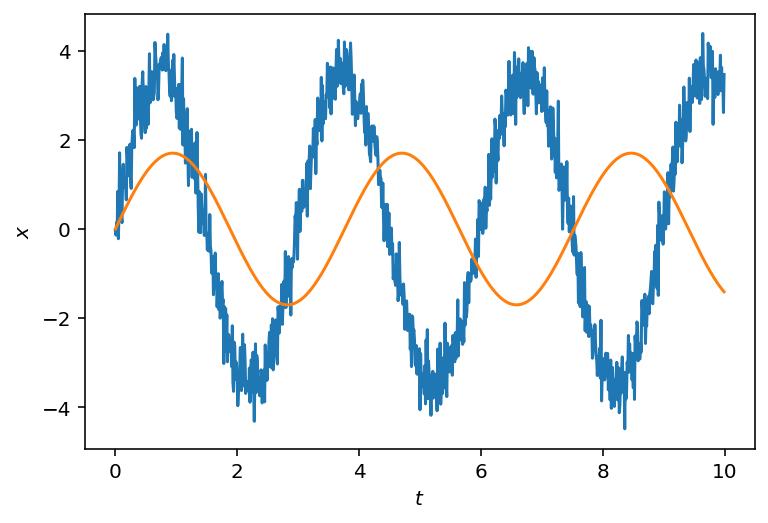

In [11]:
plt.plot(t, x_data); plt.xlabel('$t$'); plt.ylabel('$x$');
plt.plot(t, x_fit);

Let's fit the model to data through minimizing $\mathrm{Loss} = \chi^2 = \sum \frac{(\mathrm{data}-\mathrm{model})^2}{\sigma^2}$

In [12]:
def chi_squared(params, data=None, model=None, t=None, sigma=None):
    '''Return the chi squared for a model'''
    residual = data - model(params, t=t)
    return np.mean(residual**2 / sigma**2)

In [13]:
chi_squared(guess, data=x_data, model=true_model, t=t, sigma=sigma)

DeviceArray(51.63978326, dtype=float64)

Let's optimize this function.

In [14]:
from jax import grad, vmap, value_and_grad, jit

Compute functions for $$x(t) \quad \dot{x}(t) \quad \ddot{x}(t)$$ and then evaluate them.

In [15]:
def diff_eq_residuals(t, omega, model_params=None, model=None):
    '''
    The residuals of the differential equation.
    These *should* be a vector of zeros
    '''
    # x(t)
    x_of_t = lambda t_values: model(model_params, t_values)
    x = x_of_t(t)

    # First derivative
    x_dot_func = grad(x_of_t)
    x_dot = vmap(x_dot_func)(t)

    # Second derivative
    x_ddot_func = grad(x_dot_func)
    x_ddot = vmap(x_ddot_func)(t)
    
    return x_ddot + omega**2 * x

Let's check if our guessed solution satisfies the differential equation.

$$\ddot{x} + \omega^2 x = 0 $$

In [16]:
should_be_zeros = diff_eq_residuals(t, guess[1], guess, true_model)

In [17]:
np.allclose(should_be_zeros, 0)

DeviceArray(True, dtype=bool)

Yay!  Our physics-based model obeys physics!

### Let's find the best fit model using gradient descent

In [18]:
from scipy.optimize import minimize

In [19]:
result = minimize(value_and_grad(chi_squared), guess, args=(x_data, true_model, t, sigma), jac=True, 
                  method='Newton-CG')

In [20]:
result.x

DeviceArray([-0.80293005,  2.54238935], dtype=float64)

Yay! we get close to the correct answers of 3.5, 2.1!

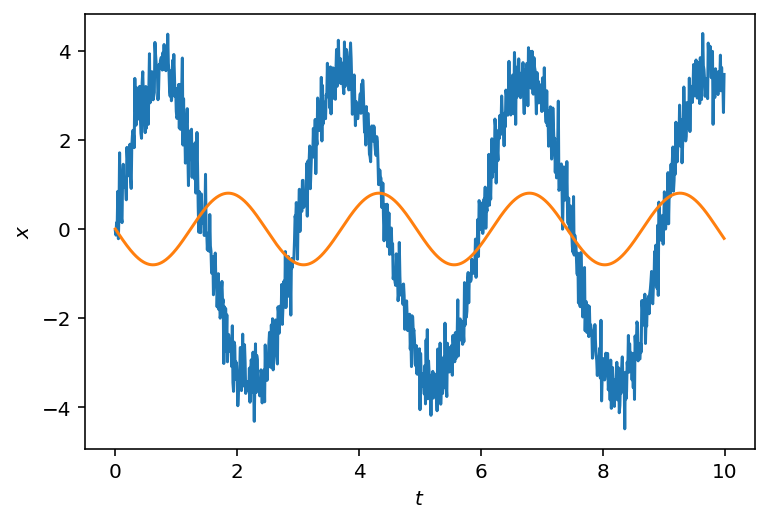

In [21]:
plt.plot(t, x_data); plt.xlabel('$t$'); plt.ylabel('$x$');
plt.plot(t, true_model(result.x, t=t));

## What if you don't know how to solve your differential equation?

Sometimes you do not know how to solve your differential equation, maybe because it is hard to solve, or it has no closed-form solution.  In this case, you can *guess* a [phenomenological model](https://en.wikipedia.org/wiki/Phenomenological_model), ideally a flexible non-parametric model.  Let's guess a 21st-order polynomial, those are pretty flexible, right?

In [22]:
def phenomenological_model(params, t=None):
    '''Return x(t) given params'''
    return np.polyval(params, t)

In [23]:
def least_squares_fit(t, x, sigma=0.42):
    '''return the least squares fit to the data'''
    A = onp.vander(t, 21)
    ATA = onp.dot(A.T, A / sigma**2)
    sigma_w = onp.linalg.inv(ATA)
    mean_w = onp.linalg.solve(ATA, onp.dot(A.T, x/sigma**2))
    return mean_w

In [24]:
coeffs = least_squares_fit(t, x_data)

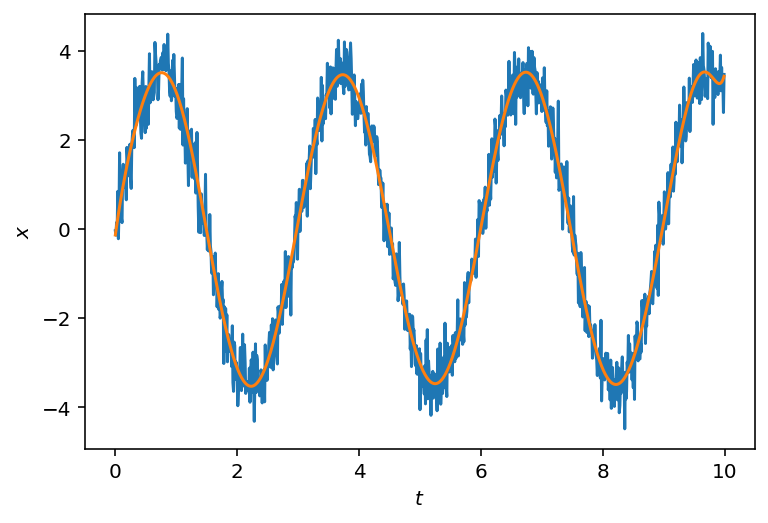

In [25]:
plt.plot(t, x_data); plt.xlabel('$t$'); plt.ylabel('$x$');
plt.plot(t, phenomenological_model(coeffs, t=t));

OK!  The phenomenological fit is not as good as our fit that employed the *true* model, but it's in the same vicinity.  But does the phenomenological model obey the physics of the differential equation of motion?

In [26]:
should_be_zeros = diff_eq_residuals(t, omega, coeffs, phenomenological_model)

In [27]:
np.allclose(should_be_zeros, 0)

DeviceArray(False, dtype=bool)

No!  Our phenomenological model does *not* obey the equations of motions, even if we know the true $\omega$ that generated the data.  

Is there *any* $\omega$ that will make our phenomenological model fit the data?  To answer that let's make a penalty for phenomological fits that deviate too much from a physical reality.

We will add a **prior** that says our phenomenological model *must obey physics*.  We will penalize the chi squared $\chi^2$ by some "loss" value $\mathcal{L}_{physics}$, which symbolized the extent to which the differential equation differs from zero:

$$ \mathcal{L}_{physics} = \sum{\frac{(\ddot{x} + \omega^2 x)^2}{\epsilon^2}}$$

where the sum is over all time samples. The numerator *should* be zero, according to the equations of motion.  The model solutions are penalized on the extent to which their differential equation solution departs from physical expectations, as controlled by an $\epsilon$ parameter.  The choice of how to set this parameter can be from dimensional analysis and scaling arguments--- the numerator has units of $\frac{distance}{time^2}$, so we can take those numbers from the data:

$$\epsilon \sim \frac{\sigma_x}{(\Delta t)^2} $$

where the numerator is the standard deviation of the data and the denominator is the time window squared:

In [28]:
epsilon = np.std(x_data) / (t.max()-t.min())**2
epsilon

DeviceArray(0.02529385, dtype=float64)

In [29]:
def physics_penalty(params, model_params=None, model=None, t=None, epsilon=None):
    '''Compute the Loss_physics that describing physical reality'''
    omega = params#[0]
    residuals = diff_eq_residuals(t, omega, model_params, model)
    return np.sum(residuals**2/epsilon**2)

In [30]:
physics_penalty(omega, coeffs, phenomenological_model, t, epsilon)

DeviceArray(1.13120616e+08, dtype=float64)

My prediction is that the solution that should best satisfy physics a a vector of zeros!  Without demanding that chi-squared is also satisfied, the optimizer will race to find any solution that makes physics satisfied.

In [31]:
penalty_of_omega = lambda omegas: physics_penalty(omegas, coeffs, phenomenological_model, t, epsilon)

In [32]:
omegas = np.arange(0.2, 3.0, 0.01)
physics_losses = vmap(penalty_of_omega)(omegas)

In [33]:
best_fit_omega = omegas[np.argmin(physics_losses)]

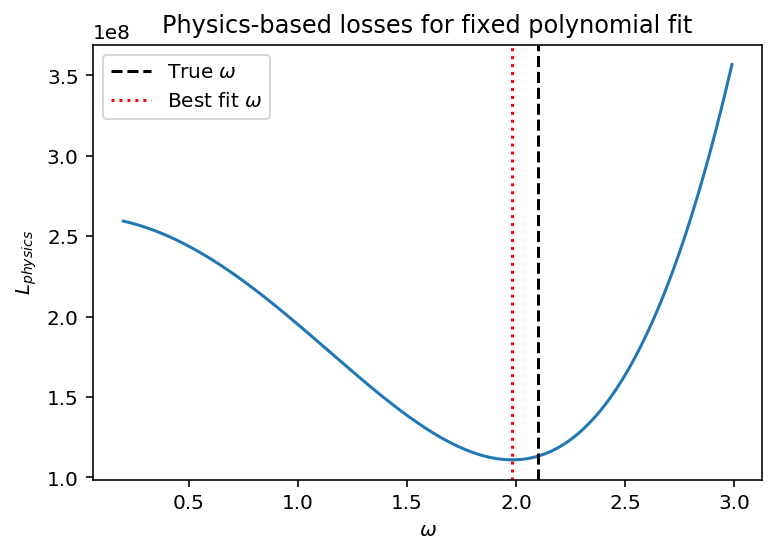

In [34]:
plt.plot(omegas, physics_losses); plt.xlabel('$\omega$');plt.ylabel('$L_{physics}$')
plt.title('Physics-based losses for fixed polynomial fit')
plt.axvline(omega, linestyle='dashed', color='k', label='True $\omega$')
plt.axvline(best_fit_omega, linestyle='dotted', color='r', label='Best fit $\omega$')
plt.legend();

In [35]:
should_be_zeros = diff_eq_residuals(t, best_fit_omega, coeffs, phenomenological_model)

It looks like the physics is *better* satisfied---for the given phenomenological model fit---when $\omega=2.01$ instead of the true value of $\omega=2.1$.  But the model does not agree with physics to within the machine precision of the computer:

In [36]:
np.allclose(should_be_zeros, 0)

DeviceArray(False, dtype=bool)

But that's assuming the phenomenological model parameters are fixed!  Let's tune the phenomenological model to both **fit the data**, and **obey the laws of physics**:

$$ \mathcal{L}_{net} = \chi^2 + \mathcal{L}_{physics} = \sum \frac{(\mathrm{data}-\mathrm{model})^2}{\sigma^2} + \sum{\frac{(\ddot{x} + \omega^2 x)^2}{\epsilon^2}}$$


In [37]:
def net_loss(net_params, data=None, model=None, t=None, sigma=None, epsilon=None):
    '''The net loss including both chi squared and physics-based losses'''
    omega = net_params[0]
    model_params = net_params[1:]
    chi_sq = chi_squared(model_params, data=data, model=model, t=t, sigma=sigma)
    physics_loss = physics_penalty(omega, model_params, model, t, epsilon)
    return chi_sq + physics_loss

In [38]:
net_params = np.hstack([2.9, coeffs])
net_loss(net_params, data=x_data, model=phenomenological_model, t=t, sigma=sigma, epsilon=epsilon)

DeviceArray(3.07532438e+08, dtype=float64)

Now let's optimize it!

In [39]:
from jax import jacrev, jacfwd

In [40]:
result = minimize(net_loss, net_params, args=(x_data, phenomenological_model, t, sigma, epsilon), 
                  jac=jacrev(net_loss),
                  hess=jacfwd(jacrev(net_loss)),
                  method='trust-krylov')

In [41]:
result.message, result.success

('A bad approximation caused failure to predict improvement.', False)

In [42]:
should_be_zeros2 = diff_eq_residuals(t, result.x[0], result.x[1:], phenomenological_model)

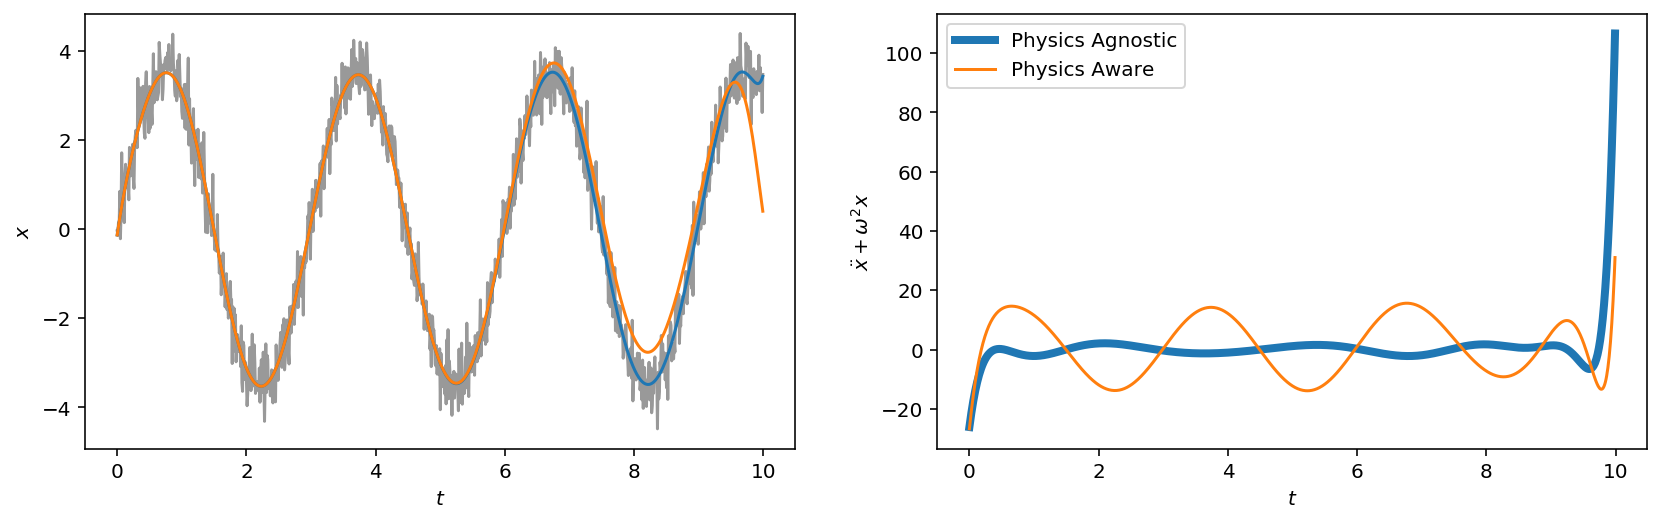

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
axes[0].plot(t, x_data, color='k', alpha=0.4); axes[0].set_xlabel('$t$'); axes[0].set_ylabel('$x$');
axes[0].plot(t, phenomenological_model(coeffs, t=t), label='Physics Agnostic');
axes[0].plot(t, phenomenological_model(result.x[1:], t=t), label='Physics Aware')
axes[1].plot(t, should_be_zeros, label='Physics Agnostic', lw=4); axes[1].set_xlabel('$t$'); 
axes[1].set_ylabel('$\ddot{x} + \omega^2 x$');
axes[1].plot(t, should_be_zeros2, label='Physics Aware'); axes[1].legend();

Cool! We see that the best fit looks smoother 

In [44]:
penalty_of_omega = lambda omegas: physics_penalty(omegas, result.x[1:], phenomenological_model, t, epsilon)

In [45]:
omegas2 = np.arange(0.2, 3.0, 0.00001)
physics_losses2 = vmap(penalty_of_omega)(omegas2)

In [46]:
best_fit_omega = omegas2[np.argmin(physics_losses2)]

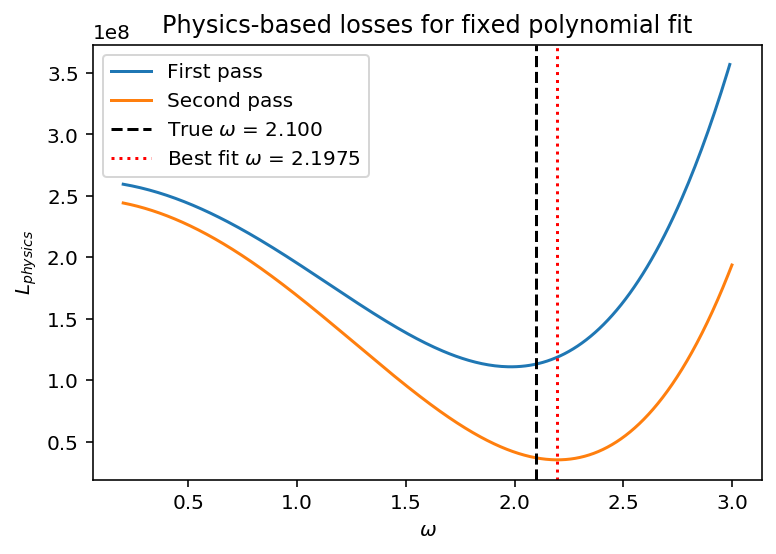

In [47]:
plt.plot(omegas, physics_losses, label='First pass'); plt.xlabel('$\omega$');plt.ylabel('$L_{physics}$')
plt.plot(omegas2, physics_losses2, label='Second pass'); plt.xlabel('$\omega$')
plt.title('Physics-based losses for fixed polynomial fit')
plt.title('Physics-based losses for fixed polynomial fit')
plt.axvline(omega, linestyle='dashed', color='k', 
            label='True $\omega$ = {:0.3f}'.format(2.1))
plt.axvline(best_fit_omega, linestyle='dotted', color='r', 
            label='Best fit $\omega$ = {:0.4f}'.format(best_fit_omega))
plt.legend(loc='best');

Cool!  We used a phenomenological model to fit data generated from the equations of motion.  We were able to constrain the fit to obey the differential equations that govern the equations of motion.  We obtained an estimate for the natural frequency of the harmonic oscillator, not even knowing how to solve the equations of motion!  

Behind the scenes, `jax` was computing the Jacobian and the Hessian of the Ordinary Differential Equations (ODE), which themselves are second order derivatives.  So in net, Jax was computing second order derivatives of scalar funtions of 22 parameters, which contained sub-computations of elementwise second order derivatives in time.  This level of higher order derivative hierarchy is profoundly cool.  

### Lessons learned and next steps

**Minimization exit code**  
The joint chi-squared and physics-based minimization---while somewhat improved---technically exited unsuccessfully.  Not only that, other minimization methods failed altogether.  I do not know enough about the inner workings of these minimization routines to have an intuition for why they failed.  

**Non-use of jit**  
Nowhere did I use jax.jit, which should dramatically speed up the computations.  I attempted to simply add an `@jit` decorator to one of the final functions, but it didn't work.  I suspect all the upstream functions have to be `jit`-ed for it to work?

**Damped harmonic oscillator**
The example here shows a simple harmonic oscillator (SHO).  It is straightforward to add a dampling term in the equations of motion proportional to $\dot{x}$.  Doing that would be neat, we would then jointly fit the natural frequency and the damping coefficient.